# Jupyter Notebooks for Data Science
> GSA Data Practitioner Summit Codealong, October 2018

# Learning Objectives
Today, we'll learn about **Jupyter Notebook** by walking through a classification challenge using a canonical toy dataset. Here's what we'll do:

* Introduce Jupyter Notebook
* Import the Iris dataset
* Perform exploratory data analysis
* Human classification excersise
* Machine learning for classification
* Use the KNN algorithm for classification

# 0. Jupyter Notebook
Jupyter Notebook is the product of a non-profit, open-source project. It provides a browser-based interactive computational environment, in which you can combine:
 - code execution
 - rich text
 - mathematical notation
 - plots
 - rich media
 
We'll see examples of these below, but you can also check some out [here](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#Markdown-basics). 

### Why Jupyter?
Jupyter Notebooks allow you to quickly iterate as you explore data sets, try different models, visualize trends, and perform many other tasks. You can execute code out-of-order, preserving context as you tweak your programs. You can even convert your notebooks into documents or slides to present to stakeholders.

# 1. The Iris Dataset
The [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set) is a **multivariate** data set introduced by the British statistician and biologist Ronald Fisher.

The iris dataset consists of $50$ **samples** from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four **features** were measured from each sample: the length and the width of the sepals and petals, in centimeters. 

Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other. Today, we'll use the [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to predict a flower's species based on its sepal and petal measurements.

>### Terminology
- **multivariate**: analysis that involves more than one outcome variable (3 iris species in our case)
- **samples**: each observation in a dataset. For us, each observation is one iris flower. We have $50$ samples for each of the three species, so we have $150$ in total ($n=150$).
- **features**: These are our independent variables, i.e. the measurements we'll use to predict the iris species. We have four features ($p=4$):  sepal length, sepal width, petal length, and petal width.

## 1.1 Get the Data
Since this dataset is so popular, it's included with Python's main machine learning library, `sklearn`. 

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
iris_data = load_iris()
iris = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris['species_num'] = iris_data.target
iris['species'] = iris.species_num.map({0:'Iris-setosa', 1:'Iris-versicolor', 2:'Iris-virginica'})
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species_num,species
0,5.1,3.5,1.4,0.2,0,Iris-setosa
1,4.9,3.0,1.4,0.2,0,Iris-setosa
2,4.7,3.2,1.3,0.2,0,Iris-setosa
3,4.6,3.1,1.5,0.2,0,Iris-setosa
4,5.0,3.6,1.4,0.2,0,Iris-setosa


# 2. "Human learning" with the iris data

**Question:** Can you predict the species of an iris using petal and sepal measurements?

We'll try to do this by:
1. Using descriptive statistics and/or basic visualizations to look for differences between the species.
2. Writing down a set of rules that could be used to predict species based on iris measurements.
3. Encoding these rules in a function that can make the predictions.

## 2.1 Inspect the data
Here, we'll use the `pandas_profiling` library to create rich HTML output that describes our dataset at a high level.

In [2]:
import pandas_profiling as profile
import matplotlib.pyplot as plt
%matplotlib inline
profile.ProfileReport(iris)

Number of variables,6
Number of observations,150
Total Missing (%),0.0%
Total size in memory,7.1 KiB
Average record size in memory,48.5 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,2


## 2.2 Describe the data
Now that we have a high-level overview, let's compute some descriptive statistics:

In [3]:
# Drop the species-num column since that's the dependent variable
iris.drop('species_num',axis=1).describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
# Get just the mean measurement for each species
iris.groupby('species').mean()

,sepal_length,sepal_width,petal_length,petal_width,species_num
species,,,,,
Iris-setosa,5.006,3.418,1.464,0.244,0
Iris-versicolor,5.936,2.770,4.260,1.326,1
Iris-virginica,6.588,2.974,5.552,2.026,2


Tables are useufl, but the human eye is better at finding patterns in visuals:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c2f3550>,
      dtype=object)

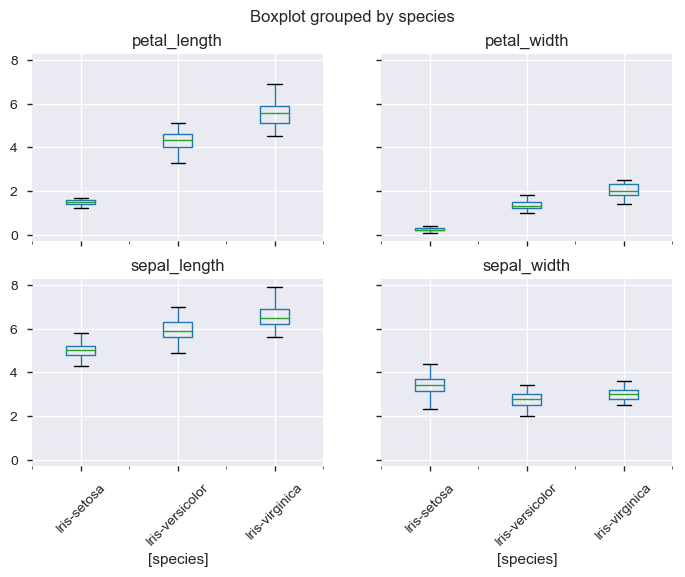

In [5]:
# box plot of all numeric columns grouped by species
iris.drop('species_num', axis=1).boxplot(by='species', rot=45)

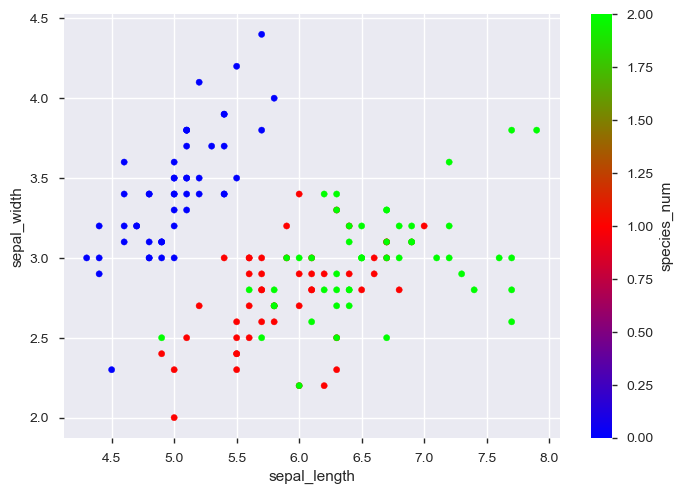

In [6]:
#scatter plot of spepal_length and sepal_width
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap='brg')

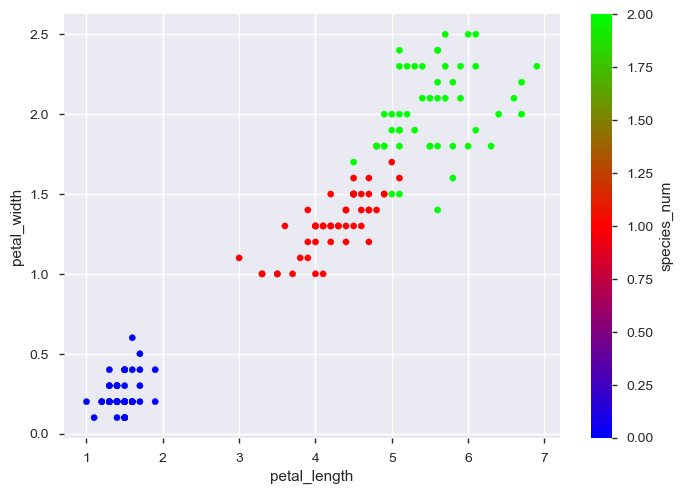

In [7]:
#scatter plot of petal_length and petal_width
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num',colormap='brg')

Those pairplots are pretty interesting! Let's see every combination at once using the `seaborn` visualization library.

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


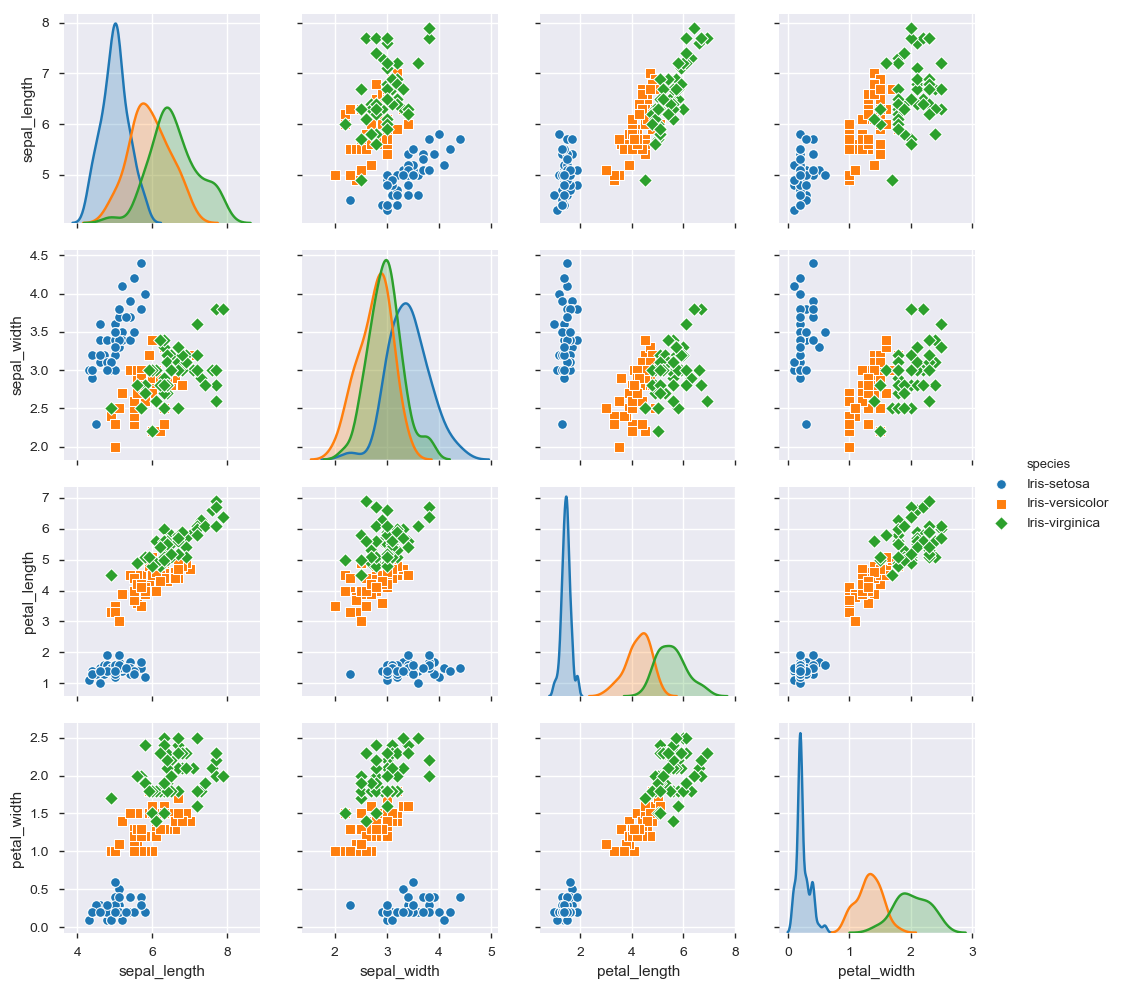

In [8]:
import seaborn as sns
g = sns.pairplot(iris.drop('species_num',axis=1), hue="species", markers=["o", "s", "D"])

## 2.3 Let's build our own classifier!
Based on the visuals above, it seems like we can make a pretty decent species classifer based solely on the `petal_length` feature.

To make our predictions we'll use some simple `if-then` statements:
 - If `petal_length` < 2.5, then we'll predict Iris-setosa ($0$)
 - Else if `petal_length` < 4.9, then we'll predict Iris Versicolor ($1$)
 - Else predict Iris Virginica ($2$)

Now, we'll encode that logic in a python function:

In [9]:
def human_classifier(data):
    if data['petal_length'] < 2.5:
        return 0
    elif data['petal_length'] < 4.9:
        return 1
    else:
        return 2

We'll now use this function to create a new column in our dataframe that contains our function's predictions for each sample:

In [27]:
iris['predictions'] = iris.apply(human_classifier,axis=1)
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species_num,species,predictions
0,5.1,3.5,1.4,0.2,0,Iris-setosa,0
1,4.9,3.0,1.4,0.2,0,Iris-setosa,0
2,4.7,3.2,1.3,0.2,0,Iris-setosa,0
3,4.6,3.1,1.5,0.2,0,Iris-setosa,0
4,5.0,3.6,1.4,0.2,0,Iris-setosa,0
5,5.4,3.9,1.7,0.4,0,Iris-setosa,0
6,4.6,3.4,1.4,0.3,0,Iris-setosa,0
7,5.0,3.4,1.5,0.2,0,Iris-setosa,0
8,4.4,2.9,1.4,0.2,0,Iris-setosa,0
9,4.9,3.1,1.5,0.1,0,Iris-setosa,0


We'll now use the `sklearn` library to calculate how accurate our predictions were. 

In [11]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(iris['species_num'],iris['predictions'])
print(f"Our classifier is {acc*100:.2f}% accurate!")

Our classifier is 95.33% accurate!


# 3. Machine Learning 101
Machine learning is a field of computer science that uses statistical **methods** to give computer systems the ability to "learn" (e.g., progressively improve performance on a specific **task**) with data, **without being explicitly programmed**.

## 3.1 Task
Generally speaking, a machine learning *task* falls into one of four categories:  
 - regression
 - clustering
 - dimensionality reduction
 - classification. 
 
Ours is a classification task. More specifically, ours is a **multiclass classification** task. Given some iris flower measurements, we need to predict the flower's species, which can be one of three different options.

<img src="http://utkuufuk.github.io/2018/06/03/one-vs-all-classification/one-vs-all.png" width=500 height=500>

## 3.2 Method
Roughly speaking, machine learning *methods* are either **supervised** or **unsupervised**. 
>**Supervised learning** involves learning a function that maps an input to an output based on example input-output pairs. You can use supervised learning when you have data that is already labeled. This is called your **training data**.<br><br>
>**Unsupervised learning** involves learning from *data that has not been labeled, classified, or categorized*. Unsupervised learning identifies commonalities in the data and reacts based on the presence or absence of such commonalities in each new piece of data.

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/Images/supervised_unsupervised.png" width = 450 height = 450>

# 4. K-nearest neighbors (KNN) for classification
When used for classification, KNN determines a sample's class membership (i.e. iris species) by seeing how "close" it is to $k$ neighbors. 

Here's a simplified visual explanation:

><img src="https://cdn-images-1.medium.com/max/1600/0*Sk18h9op6uK9EpT8." width = 450 height = 450>
>The test sample (green circle) must be classified either to the first class of blue squares or to the second class of red triangles.<br><br>
>If $k = 1$, then KNN assigns the test sample to the first class since the nearest neighbor is the $1$ square inside of the inner circle.<br><br>
>If $k = 3$, KNN assigns the test sample to the second class since there are now $2$ triangles and only 1 square within the $3$-neighbor range.

## 4.1 Visualizing the KNN algorithm
To get a better feel for the KNN algorithm - and to demo how useful Jupyter Notebooks can be - we'll use the KNN algorithm on our iris data, adjusting $k$ to see the effects.

Here's how the algorithm works:
1. Pick a value for $k$.
2. Search for the $k$ observations in the data that are "nearest" to the measurements of the unknown iris.
    - [Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) is often used as the distance metric, but other metrics are allowed.
3. Use the most popular response value from the $k$ "nearest neighbors" as the predicted response value for the unknown iris.

Below, we'll define some functions to help us visualize this.

In [12]:
# defining some helper functions
from matplotlib.colors import ListedColormap
from sklearn import neighbors

def plot_boundaries(X,y,n_neighbors,h=.01):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#b1ffaa'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF','#22c313'])


    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = -1, X.max()+1
    y_min, y_max = -1, X.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


    plt.show()

def viz_new_point(X, y, vanilla, citrus, n_neighbors, h=.01):
    plt.clf()
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#b1ffaa'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF','#22c313'])
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
    clf.fit(X, y)
    x_min, x_max = -1, X.max()+1
    y_min, y_max = -1, X.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


    # Put in our new Predictions
    new_pred = np.array([vanilla, citrus])
    new_pred_class = clf.predict(new_pred.reshape(1,-1))

    pred_co = lambda x: 'b' if x == 1 else 'r'

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.scatter(new_pred[0], new_pred[1], c=pred_co(new_pred_class), marker='x', cmap=cmap_bold)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.show()

Since it's kind of tough to visualize 4 dimensions, we'll choose just two flower measurements to visualize how the KNN algorithm works.

In [13]:
features = ['sepal_length','sepal_width']
X = np.array(iris[features]) #make a matrix of our flower measurements
y = np.array(iris['species_num']) #make an array containing the species numbers

k=1


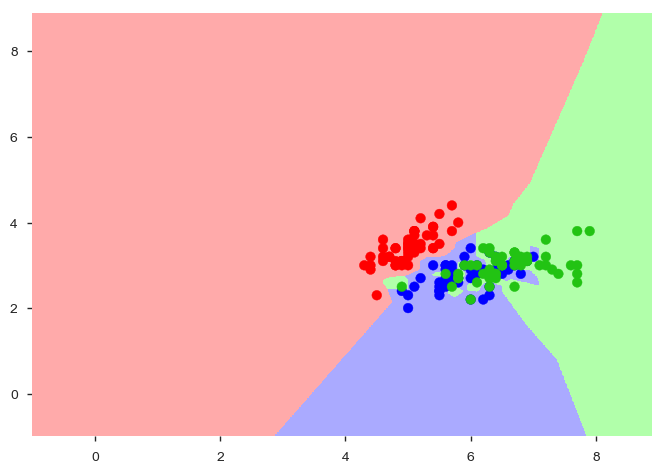

k=3


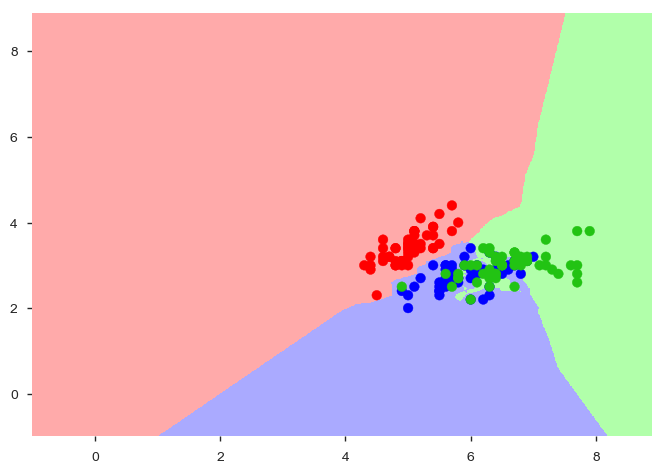

k=5


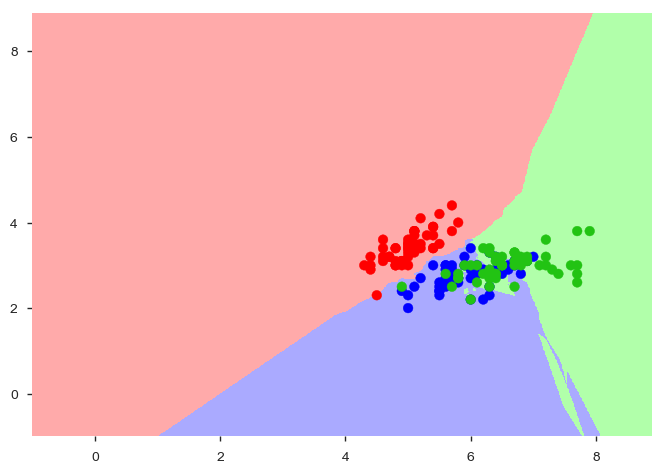

k=7


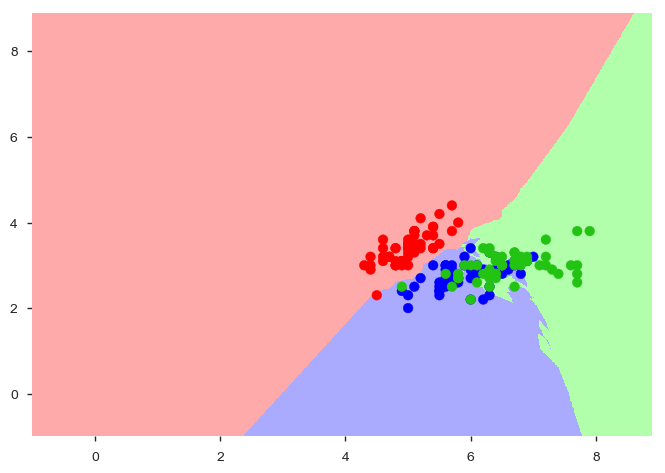

k=9


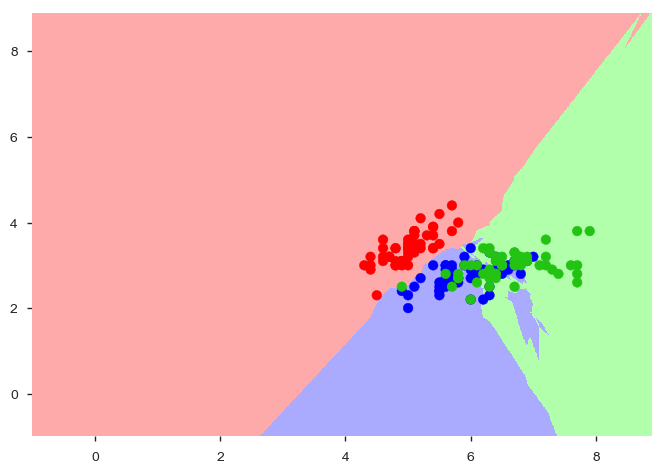

k=11


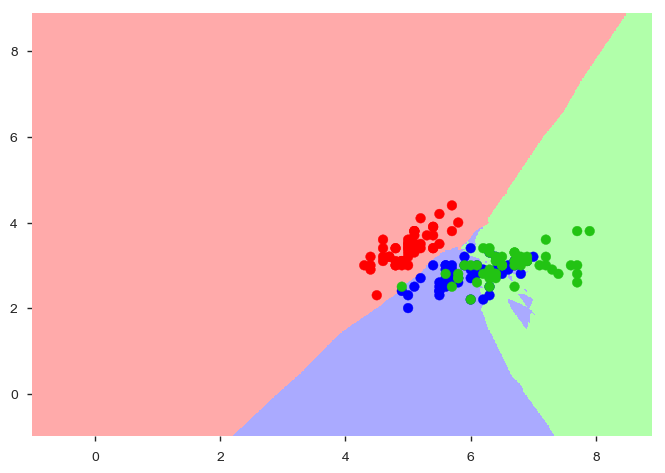

k=13


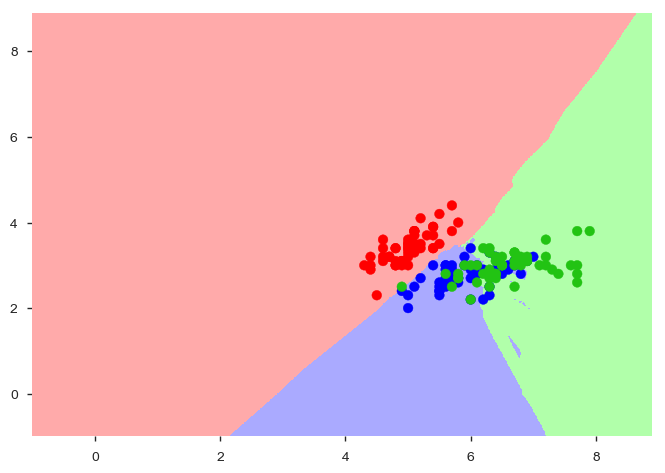

In [14]:
#choose various values for k and see how the decision boundaries are drawn
for k in range(1,14,2):
    print(f'k={k}')
    plot_boundaries(X,y,k)

# 5. Create a KNN classifier

**Step 1:** Make your data:

In [15]:
# we'll use all four measurements instead of just 2
features = ['sepal_length','sepal_width','petal_length','petal_width']
X = iris[features]
y = iris['species_num']

**Step 2:** Import the classifier:

In [16]:
from sklearn.neighbors import KNeighborsClassifier

**Step 3:** "Instantiate" the "estimator"

- "Estimator" is scikit-learn's term for "model"
- "Instantiate" means "make an instance of"

In [17]:
# make an instance of a KNeighborsClassifier object
knn = KNeighborsClassifier()

Above, we created an object that "knows" how to do K-nearest neighbors classification, and is just waiting for data. It's at this point that you'd want specify the `k` and other paramaters. We'll just use the defaults for now.

**Step 4:** Fit the model with data (aka "model training")

- Model is "learning" the relationship between `X and y` in our "training data"

In [18]:
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

**Step 4:** Predict the response for a new observation

- New observations are called "out-of-sample" data
- The fitted model uses the information it learned during the model training process to make the prediction

In [19]:
y_pred = knn.predict(X)

**Step 5**: Evaluate the predictions

 - There's a number of metrics you can use to determine how "good" your predictions were. 
 
Here' we'll look at just about all of them using `classification_report` and `confusion_matrix`. But first, let's see if we improved upon the accuracy score we got when we created our own function to make the species predictions:

In [20]:
knn_acc = accuracy_score(y,y_pred)
print(f"Our classifier is {knn_acc*100:.2f}% accurate!")

Our classifier is 96.67% accurate!


In [21]:
from sklearn.metrics import classification_report
target_names = ['setosa', 'versicolor', 'virginica']
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        50
 versicolor       0.96      0.94      0.95        50
  virginica       0.94      0.96      0.95        50

avg / total       0.97      0.97      0.97       150



And here we'll check out a confusion matrix:

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

We can use a **confusion matrix** to evaluate our classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

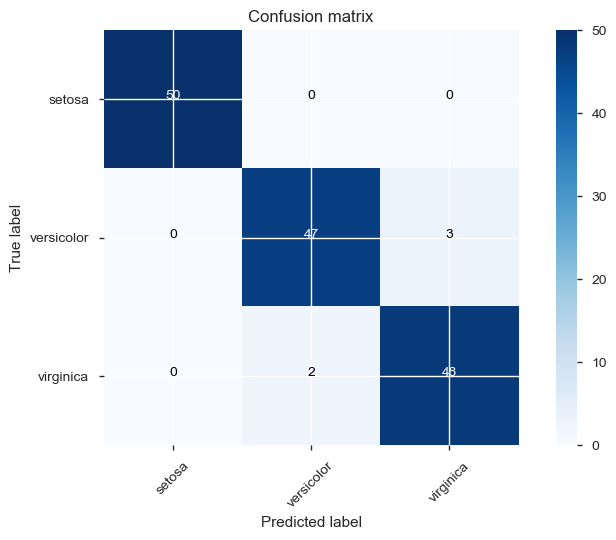

In [23]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')

## 5.1 Evaluate several KNN classifiers
Above, we used the default value for k ($k=5$) and did pretty well. We only made 5 incorrect predictions! Let's see how adjusting `k` effects our predictions:

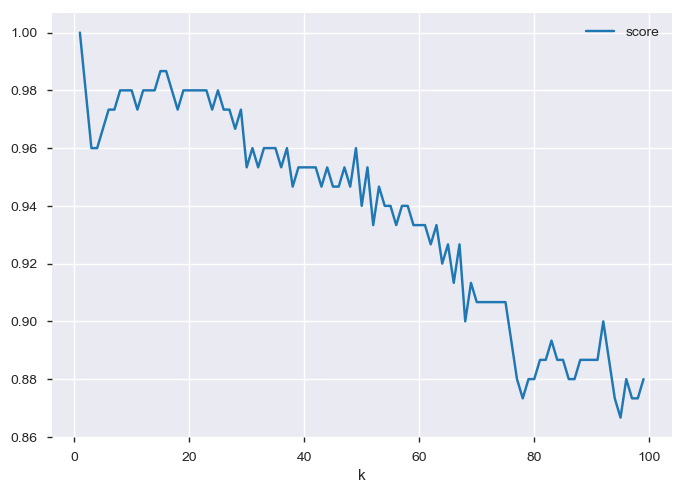

In [24]:
scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y)
    pred = knn.predict(X)
    score = float(sum(pred == y)) / len(y)
    scores.append([k, score])

data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score')
plt.show()

# Bonus - Gridsearch

In the above example, we ran our model several times using a for-loop on different values of `k`.

Sklearn provides a framework for automatically completeing this process, and letting us tune our model across many parameters! Its called [GridSearch](http://scikit-learn.org/stable/modules/grid_search.html), and it works by letting us provide a grid (dictionary) of parameters and letting us run through them as if the model was in a chain of nested for loops. You can even test other algorithms at the same time!

>**Caution** - parameter depth is multiplicative, which can get away from you very quickly.<br><br>
>For example, if we searched through a KNN model with 10 values of K and 2 weighting options, we would be running our model 20 times (before factoring in cross validation). For algorithms with many parameters, this can quickly lead to running 100's if not 1000's of iterations of your model

In [25]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': list(range(1,21)),
         'weights':['uniform','distance'],
         'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
         'p':[1,2]}

In [26]:
gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=params,
                  cv=3,
                  n_jobs=-1,
                  verbose=1)
gs.fit(X,y)
print("-"*80)
print(f"Our best accuracy score was {gs.best_score_}!")

print(f"The best parameters were:  {gs.best_params_}")
print("-"*80)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    1.5s


--------------------------------------------------------------------------------
Our best accuracy score was 0.9866666666666667!
The best parameters were:  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    3.6s finished
